In [18]:
%load_ext autoreload
%autoreload 2

# Test partitioning update

In [2]:
from aerospace_chatbot.processing import DocumentProcessor
from aerospace_chatbot.services import EmbeddingService, RerankService, LLMService, DatabaseService
from aerospace_chatbot.processing import QAModel

from langchain_core.documents import Document

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

# Initialize logger
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [3]:
db_type='Pinecone'

embedding_service='OpenAI'
embedding_model='text-embedding-3-large'

rerank_service='Cohere'
rerank_model='rerank-v3.5'

llm_service='OpenAI'
llm_model='gpt-4o'
# llm_service='Anthropic'
# llm_model='claude-3-5-sonnet-latest'

chunk_size=400
chunk_overlap=0
batch_size=50
index_name = 'text-embedding-3-large-test'

test_prompt='How does a thermal knife function in a cable based hold down release mechanism?'

In [4]:
# Initialize services
embedding_service = EmbeddingService(
    model_service=embedding_service,
    model=embedding_model
)

rerank_service = RerankService(
    model_service=rerank_service,
    model=rerank_model
)

llm_service = LLMService(
    model_service=llm_service,
    model=llm_model,
)

doc_processor = DocumentProcessor(
    embedding_service=embedding_service,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Initialize database service
db_service = DatabaseService(
    db_type=db_type,
    index_name=index_name,
    embedding_service=embedding_service,
    rerank_service=rerank_service,
)

In [ ]:
bucket_name = 'processing-pdfs'
docs = DocumentProcessor.list_bucket_pdfs(bucket_name)
docs

In [ ]:
partitioned_docs = doc_processor.load_and_partition_documents(docs,partition_by_api=False, upload_bucket=bucket_name)
partitioned_docs

In [ ]:
chunk_obj, output_paths = doc_processor.chunk_documents(partitioned_docs)

In [8]:
# try:
#     db_service.initialize_database(clear=False)
# except ValueError as e:
#     print(f"Database initialization failed: {str(e)}")
#     print(e)
#     raise e

In [9]:
# db_service.index_data(chunk_obj)

In [ ]:
# k_retrieve=20
# k_rerank=5
# config = {"configurable": {"thread_id": "1"}}

# qa_model = QAModel(
#     db_service=db_service,
#     llm_service=llm_service,
#     k_retrieve=k_retrieve,
#     k_rerank=k_rerank,
#     memory_config=config
# )

In [11]:
# qa_model.query(test_prompt)

In [12]:
# print(qa_model.result[-1]['references'])
# print(qa_model.sources[-1])
# print(qa_model.scores[-1])


In [13]:
# print(qa_model.ai_response)

# Langgraph

Run above section first


In [14]:
from langchain_core.messages import SystemMessage, RemoveMessage
from langchain.output_parsers import PydanticOutputParser
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain.prompts import PromptTemplate

from typing_extensions import List
from typing import List, Literal, Tuple

# import cohere
# import os
from langchain.docstore.document import Document

from aerospace_chatbot.services.prompts import InLineCitationsResponse, AltQuestionsResponse, style_mode, CHATBOT_SYSTEM_PROMPT, QA_PROMPT, SUMMARIZE_TEXT, GENERATE_SIMILAR_QUESTIONS_W_CONTEXT

In [15]:
retriever = db_service.retriever
llm = llm_service.get_llm()
# memory = MemorySaver()

## Rerank

In [ ]:
# Retrieve docs with standard retriever
retrieved_docs = retriever.invoke(test_prompt)

# retrieved_docs

In [17]:
# COHERE_API_KEY = os.getenv("COHERE_API_KEY")
# co = cohere.ClientV2(COHERE_API_KEY)
# rerank_model = "rerank-v3.5"

In [18]:
# model_list = co.models.list()
# rerank_model_info = next((model for model in model_list.models if model.name == rerank_model), None)
# print(rerank_model_info)

# print(model_list.models)

In [19]:
# Get token count for each doc
# max_context_length = 4096

# token_count_list = []
# for doc in retrieved_docs[0]:
#     tokens = co.tokenize(
#         model=rerank_model,
#         text=doc.page_content,
#     )
#     token_count_list.append(len(tokens.tokens))
    # print(token_count)

# print(token_count_list)

In [20]:
# def cohere_rerank(query: str, retrieved_docs: List[Tuple[Document, float]], top_n: int = None):
#     # retrieved_docs contains a list of tuples, where the first element is the document and the second is the score
#     # Cohere's rerank expects a list of strings; we'll supply the page_content

#     if top_n is None:
#         top_n = 3
#     elif top_n < 3:
#         raise ValueError("top_n must be at least 3")
#     elif top_n > len(retrieved_docs):
#         raise ValueError("top_n must be less than or equal to the number of retrieved documents")
    
#     inputs = [doc.page_content for doc, _ in retrieved_docs]

#     # Call Cohere's Rerank endpoint
#     response = co.rerank(
#         model=rerank_model,
#         query=query,
#         documents=inputs,
#         top_n=top_n
#     )

#     # Create a dictionary to map document IDs to rerank scores
#     rerank_scores = {retrieved_docs[i][0].id: item.relevance_score for i, item in enumerate(response.results)}

#     # Create list of (doc, original_score, rerank_score) tuples
#     doc_scores = []
#     for doc, original_score in retrieved_docs:
#         rerank_score = rerank_scores.get(doc.id, None)  # Get the rerank score or None if not available
#         doc_scores.append((doc, original_score, rerank_score))

#     # Sort docs by rerank score in descending order, placing those without a rerank score at the end
#     doc_scores_sorted = sorted(doc_scores, key=lambda x: (x[2] is not None, x[2]), reverse=True)

#     return doc_scores_sorted

In [ ]:
reranked_docs = db_service.rerank(test_prompt, retrieved_docs, top_n=k_rerank)
# reranked_docs

In [22]:
# Add context to the prompt
# TODO update this to use the doc.id. Do some testing to check this works.
docs_content=""
for i, (doc, original_score, rerank_score) in enumerate(reranked_docs):
    # Source IDs in the order they show in in the array. Indexed from 0.
    if rerank_score is not None:    # Only include docs with a rerank score
        docs_content += f"Source ID: {i+1}\n{doc.page_content}\n\n"

# print(docs_content)

## Test output parser

### InLineCitationsResponse

In [ ]:
# Should validate
valid_response = InLineCitationsResponse(content="""
The actuator was tested under high pressure <source id="1">. 
Material properties were measured over 50 cycles <source id="2">.
Thermal resistance improved by 30% <source id="3">.
""",
citations=["1", "2", "3"]
)

print(valid_response)

In [ ]:
# Shouldn't validate
try:
    invalid_response = InLineCitationsResponse(content="""
    The actuator was tested under high pressure [1]. 
    Material properties were measured under load <source id="x">.
    """,
    citations=["1", "x"]
    )
except ValueError as e:
    print(f"Validation failed: {e}")

In [26]:
QA_PROMPT_TEST=PromptTemplate(
    template=
"""
# **System Prompt**

Your name is **Aerospace Chatbot**, a specialized assistant for flight hardware design and analysis in aerospace engineering. You will function as a knowledgeable replacement for an expert in aerospace flight hardware design, testing, analysis, and certification.

> **Important Note:** The **Sources and Context** you are provided are ranked from most relevant to least relevant by a state-of-the-art retrieval and ranking tool. Please take this ranking into consideration when determining which sources to cite.

Use only the **Sources and Context** provided to answer the **User Question**. **Do not use outside knowledge**, and strictly follow these rules:

---

## **Rules**:

1. **Answer only based on the provided Sources and Context.**  
   - If the information is not available in the Sources and Context, respond with:  
     *"I don’t know the answer to that based on the information provided. You might consider rephrasing your question or asking about a related topic."*  
   - **If no sources are truly relevant to the answer, do not cite any sources.**

2. **Do not make up or infer answers.**  
   - Stay accurate and factual at all times.

3. **Provide highly detailed, explanatory answers.**  
   - Include **as many specific details from the original context** as possible to thoroughly address the user’s question.

4. **Provide responses in English only** and format them using **Markdown** for clarity.

5. **Cite Sources in context** using the exact format `<source id="#">`:  
   - `#` – Represents the numerical order of the source as provided in the Sources and Context.  
   - **The `source` tag must be present for every source referenced in the response.**  
   - **Do not add, omit, or modify any part of the citation format.**  
   
   **Examples (Correct):**  
   > The actuator was tested under extreme conditions <source id="1">.  
   > A secondary material exhibited increased yield strength <source id="2">.  
   > Additional research confirmed thermal properties <source id="3">.  

   **Examples (Incorrect – Must Be Rejected):**  
   > Testing yielded higher efficiency [1] (Incorrect bracket format)  
   > <source id="1" > (Extra space after `id`)  
   > <source id="a"> (Non-numeric ID)  
   > <source id="1,2"> (Multiple IDs in one tag – invalid)  

6. **Every sentence or paragraph that uses a source must cite it with the format `<source id="#">`.**  
   - **Do not group multiple sources into a single tag.**  
   - Each source must have its own, clearly separated citation.  
   - For example:  
     > The actuator uses a reinforced composite structure <source id="1">.  
     > This design was validated through multiple tests <source id="2">.

7. **Validation Requirement:**  
   - If the response contains references without the exact `<source id="#">` format, the response must be flagged or rejected.  
   - Every source used must have a corresponding citation in the response.  
   - **No source should be referenced without explicit citation.**

8. **Suggest related or alternative questions** if applicable, to help the user find relevant information within the corpus.

9. **Always cite Source ID: 1**  
   - Always provide a citation for Source ID: 1 unless it is entirely irrelevant to the user’s question (in which case explicitly omit it).  
   - Follow Rule #10 for the other sources.

10. **Give preference to citing top-ranked sources, provided in order of highest to lowest relevance.**  
   - If the first sources in the list (i.e., the most relevant or highest-ranked) contain information that addresses the user’s question, cite them first.  
   - Then cite additional sources only if they contain new or non-redundant details.  
   - If the top-ranked sources are not relevant, skip them.

---
**Sources and Context**:
{context}
---

---
**User Question**:
{question}
---

---
{format_instructions}
---
""",
    input_variables=["context", "question"],
    partial_variables={"format_instructions": PydanticOutputParser(pydantic_object=InLineCitationsResponse).get_format_instructions()},
)


In [ ]:
raw_output = llm.invoke(QA_PROMPT_TEST.format(context=docs_content, question=test_prompt))
print(raw_output.content)

In [ ]:
parsed_response = PydanticOutputParser(pydantic_object=InLineCitationsResponse).parse(raw_output.content)
print(parsed_response)

### AltQuestionsResponse

In [ ]:
# Should validate
valid_response = AltQuestionsResponse(
    questions=["What is the purpose of the actuator?", "What are the key components of the mechanism?", "How does the mechanism work?"],
)
print(valid_response)

In [ ]:
# Shouldn't validate
try:
    invalid_response = AltQuestionsResponse(
        questions=["What is the purpose of the actuator?", "What are the key components of the mechanism?"],
    )
except ValueError as e:
    print(f"Validation failed: {e}")

In [ ]:
raw_output = llm.invoke(GENERATE_SIMILAR_QUESTIONS_W_CONTEXT.format(context=docs_content, question=test_prompt))
print(raw_output.content)

In [ ]:
parsed_response = PydanticOutputParser(pydantic_object=AltQuestionsResponse).parse(raw_output.content)
print(parsed_response.questions)

## Define graph

In [33]:
# class State(MessagesState):
#     context: List[Tuple[Document, float, float]]
#     cited_sources: List[Tuple[Document, float, float]]
#     summary: str

# # Define application steps
# def retrieve(state: State):
#     """
#     Retrieve the documents from the database.
#     """
#     logger.info(f"Node: retrieve")

#     # Retrieve docs
#     retrieved_docs = retriever.invoke(state["messages"][-1].content)
#     logger.info(f"Retrieved docs")
#     # Rerank docs
#     # reranked_docs = cohere_rerank(
#     #     state["messages"][-1].content, 
#     #     retrieved_docs, 
#     #     top_n=k_rerank
#     # )
#     reranked_docs = db_service.rerank(
#         state["messages"][-1].content, 
#         retrieved_docs, 
#         top_n=k_rerank
#     )
#     logger.info(f"Reranked docs")

#     return {"context": reranked_docs}

# def generate_w_context(state: State):
#     """
#     Call the model with the prompt with context.
#     """
#     logger.info(f"Node: generate_w_context")

#     # Get the summary, add system prompt
#     summary = state.get("summary", "")
#     system_prompt = CHATBOT_SYSTEM_PROMPT.format(style_mode=style_mode(style))
#     logger.info(f"generate_w_context system prompt: {system_prompt.content}")
#     if summary:
#         system_message = f"Summary of conversation earlier: {summary}"
#         messages = [system_prompt] + [SystemMessage(content=system_message)] + state["messages"]
#     else:
#         messages = [system_prompt] + state["messages"]

#     # Add context to the prompt
#     docs_content=""
#     for i, (doc, retrieved_score, rerank_score) in enumerate(state["context"]):
#         # Source IDs in the order they show in in the array. Indexed from 1, retrieve with 0 index.
#         if rerank_score is not None:    # Only include docs with a rerank score
#             docs_content += f"Source ID: {i+1}\n{doc.page_content}\n\n"

#     # Prompt with context and pydantic output parser
#     prompt_with_context = QA_PROMPT.format(
#         context=docs_content,
#         question=state["messages"][-1].content, 
#     )
#     # Replace the last message (user question) with the prompt with context, return LLM response
#     messages[-1] = prompt_with_context 
#     response = llm.invoke(messages)

#     # Parse the response. This will return a InLineCitationsResponse object. 
#     # This object has two fields: content and citations.
#     # Replace the last message with the content of the parsed and validated response. 
#     # AIMessage metadata will be incorrect.
#     parsed_response = PydanticOutputParser(pydantic_object=InLineCitationsResponse).parse(response.content)
#     response.content = parsed_response.content

#     # Return cited_sources as the list of tuples that matched the citations.
#     existing_cited_sources = state.get("cited_sources", [])  # Grab whatever might already be in cited_sources
#     cited_sources = [state["context"][int(citation)-1] for citation in parsed_response.citations]
#     existing_cited_sources.append(cited_sources)  # Append the new list as a sublist
#     state["cited_sources"] = existing_cited_sources

#     # Update the state messages with the messages updated in this node.
#     state["messages"] = messages
#     return {"messages": [response], 
#             "cited_sources": state["cited_sources"]}

# def should_continue(state: State) -> Literal["summarize_conversation", END]:
#     """
#     Define the logic for determining whether to end or summarize the conversation
#     """
#     logger.info(f"Node: should_continue")

#     # If there are more than six messages, then we summarize the conversation
#     messages = state["messages"]
#     if len(messages) > 6:
#         logger.info(f"Summarizing conversation")
#         return "summarize_conversation"
    
#     # Otherwise just end
#     logger.info(f"Ending conversation")
#     # logger.info(f"Messages before ending: {messages}")
#     return END

# def summarize_conversation(state: State):
#     """
#     Summarize the conversation
#     """
#     logger.info(f"Node: summarize_conversation")

#     summary = state.get("summary", "")
#     if summary:
#         # If a summary already exists, extend it
#         summary_message = SUMMARIZE_TEXT.format(
#             summary=summary,
#             augment="Extend the summary provided by taking into account the new messages above."
#         )
#     else:
#         # If no summary exists, create one
#         summary_text="""---\n**Conversation Summary to Date**:\n{summary}\n---"""
#         summary_message = SUMMARIZE_TEXT.format(
#             summary=summary_text,
#             augment="Create a summary of the conversation above."
#         )

#     messages = state["messages"] + [summary_message]
#     response = llm.invoke(messages)

#     # Prune messages. This deletes all but the last two messages
#     delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
#     return {"summary": response.content, "messages": delete_messages}

In [34]:
# # Compile application and test
# workflow = StateGraph(State)

# # Define nodes
# workflow.add_node("retrieve", retrieve) 
# workflow.add_node("generate_w_context", generate_w_context)
# workflow.add_node("summarize_conversation", summarize_conversation)

# # Define edges
# workflow.add_edge(START, "retrieve")
# workflow.add_edge("retrieve", "generate_w_context")

# # We now add a conditional edge
# workflow.add_conditional_edges(
#     "generate_w_context",   # Define the start node. We use `generate_w_context`. This means these are the edges taken after the `conversation` node is called.
#     should_continue,    # Next, pass in the function that will determine which node is called next.
# )

# # Add a normal edge from `summarize_conversation` to END. This means that after `summarize_conversation` is called, we end.
# workflow.add_edge("summarize_conversation", END)

# # Compile the workflow
# app = workflow.compile(checkpointer=memory)

In [ ]:
qa_model.workflow

## Run Graph

In [36]:
config = {"configurable": {"thread_id": "197"}}

In [ ]:
prompt = 'My name is Dan. Please tell me about some interesting mecanism designs.'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
qa_model.query(prompt)
for message in qa_model.result['messages']:
    message.pretty_print()

In [ ]:
qa_model.result['context']

In [ ]:
# prompt = 'How have these mecahnisms been tested?'
prompt = 'How is release indicated from the functional response of the mechanism?'
result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
for message in result['messages']:
    message.pretty_print()

In [ ]:
result

In [ ]:
result['messages'][-1].content

In [ ]:
print(result['context'][0][0])

## Test PDF annotation

In [ ]:
import json, base64, zlib

def extract_orig_elements(orig_elements):
    decoded_orig_elements = base64.b64decode(orig_elements)
    decompressed_orig_elements = zlib.decompress(decoded_orig_elements)
    return decompressed_orig_elements.decode('utf-8')

orig_elements = extract_orig_elements(result['context'][2][0].metadata['orig_elements'])
orig_elements = json.loads(orig_elements)
print(orig_elements)
print(len(orig_elements))

In [ ]:
page_range = [orig_elements[0]['metadata']['page_number'], orig_elements[-1]['metadata']['page_number']]
print(page_range)

In [ ]:
from aerospace_chatbot.ui.utils import display_source_highlights

annotated_pdfs = display_source_highlights(result['context'][:k_rerank])
print(len(annotated_pdfs))

In [ ]:
import fitz
from IPython.display import display, Image
from tempfile import NamedTemporaryFile

pdf_bytes = annotated_pdfs[1].read()
pdf_document = fitz.open(stream=pdf_bytes, filetype="pdf")

# Display each page
for page in pdf_document:
    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1))  # 2x zoom for better resolution
    with NamedTemporaryFile(suffix='.png') as tmp:
        pix.save(tmp.name)
        display(Image(filename=tmp.name))

pdf_document.close()

## Summary memory test prompts

In [157]:
# prompt = 'How old are you?'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

In [158]:
# prompt = 'What are some lessons learned about these mechanisms?'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

In [159]:
# prompt = 'What are some problems that have occurred?'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
# for message in result['messages']:
#     message.pretty_print()

# RAGatouille retrieval testing

In [32]:
from aerospace_chatbot.processing import DocumentProcessor
from aerospace_chatbot.services import EmbeddingService, RerankService, LLMService, DatabaseService
from aerospace_chatbot.processing import QAModel

from langchain_core.documents import Document

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)
# Set LOCAL_DB_PATH environment variable
# os.environ['LOCAL_DB_PATH'] = os.path.abspath('.')

# Initialize logger
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
db_type='RAGatouille'

embedding_service='RAGatouille'
embedding_model='colbert-ir/colbertv2.0'

rerank_service='Cohere'
rerank_model='rerank-v3.5'

llm_service='OpenAI'
llm_model='gpt-4o'
# llm_service='Anthropic'
# llm_model='claude-3-5-sonnet-latest'

chunk_size=400
chunk_overlap=0
batch_size=50
index_name = 'ragatouille-test'

test_prompt='How does a thermal knife function in a cable based hold down release mechanism?'
# Initialize services
embedding_service = EmbeddingService(
    model_service=embedding_service,
    model=embedding_model
)

rerank_service = RerankService(
    model_service=rerank_service,
    model=rerank_model
)
# rerank_service = None

llm_service = LLMService(
    model_service=llm_service,
    model=llm_model,
)

doc_processor = DocumentProcessor(
    embedding_service=embedding_service,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Initialize database service
db_service = DatabaseService(
    db_type=db_type,
    index_name=index_name,
    embedding_service=embedding_service,
    rerank_service=rerank_service,
)


In [48]:
bucket_name = 'processing-pdfs'
docs = DocumentProcessor.list_bucket_pdfs(bucket_name)

# partitioned_docs = doc_processor.load_and_partition_documents(docs,partition_by_api=False, upload_bucket=bucket_name)
# chunk_obj, output_paths = doc_processor.chunk_documents(partitioned_docs)

partitioned_docs = doc_processor.load_partitioned_documents(docs, partition_dir='./document_processing')
chunk_obj, output_paths = doc_processor.chunk_documents(partitioned_docs)

INFO:aerospace_chatbot.processing.documents:Number of PDFs found: 2
INFO:aerospace_chatbot.processing.documents:PDFs found: ['gs://processing-pdfs/1999_christiansen_reocr.pdf', 'gs://processing-pdfs/1999_cremers_reocr.pdf']
INFO:aerospace_chatbot.processing.documents:Found existing partitioned file: ./document_processing/partitioned/1999_christiansen_reocr-partitioned.json
INFO:aerospace_chatbot.processing.documents:Found existing partitioned file: ./document_processing/partitioned/1999_cremers_reocr-partitioned.json
INFO:aerospace_chatbot.processing.documents:Chunking documents...
INFO:aerospace_chatbot.processing.documents:Total number of chunks: 91
INFO:aerospace_chatbot.processing.documents:Output paths: ['./document_processing/chunked/1999_christiansen_reocr-chunked.json', './document_processing/chunked/1999_cremers_reocr-chunked.json']


./document_processing/partitioned/1999_christiansen_reocr-partitioned.json
./document_processing/partitioned/1999_cremers_reocr-partitioned.json
Chunking ./document_processing/partitioned/1999_christiansen_reocr-partitioned.json...
Chunked data saved at ./document_processing/chunked/1999_christiansen_reocr-chunked.json
Chunking ./document_processing/partitioned/1999_cremers_reocr-partitioned.json...
Chunked data saved at ./document_processing/chunked/1999_cremers_reocr-chunked.json


In [34]:
try:
    db_service.initialize_database(clear=False)
except ValueError as e:
    print(f"Database initialization failed: {str(e)}")
    print(e)
    raise e

INFO:aerospace_chatbot.services.database:Validating index ragatouille-test
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
INFO:aerospace_chatbot.services.database:RAGatouille index ragatouille-test initialized


In [44]:
db_service.vectorstore.index

<bound method RAGPretrainedModel.index of <ragatouille.RAGPretrainedModel.RAGPretrainedModel object at 0x32b00c750>>

In [35]:
# db_service.index_data(chunk_obj)

In [36]:
k_retrieve=20
k_rerank=5
config = {"configurable": {"thread_id": "2"}}

qa_model = QAModel(
    db_service=db_service,
    llm_service=llm_service,
    k_retrieve=k_retrieve,
    k_rerank=k_rerank,
    memory_config=config
)

In [37]:
docs = qa_model.db_service.retriever.invoke(test_prompt)

Loading searcher for index ragatouille-test for the first time... This may take a few seconds
[Jan 25, 21:03:56] #> Loading codec...
[Jan 25, 21:03:56] #> Loading IVF...
[Jan 25, 21:03:56] #> Loading doclens...


/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rele

[Jan 25, 21:03:56] #> Loading codes and residuals...



  0%|          | 0/1 [00:00<?, ?it/s]/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for a

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . How does a thermal knife function in a cable based hold down release mechanism?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2129, 2515, 1037, 9829, 5442, 3853, 1999, 1037, 5830, 2241,
        2907, 2091, 2713, 7337, 1029,  102,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])




/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [38]:
docs

[(Document(id='998394a9-744c-41b9-ac54-322877258f33', metadata={'data_source.url': 'gs://processing-pdfs/1999_cremers_reocr.pdf', 'data_source.record_locator.protocol': 'gs', 'data_source.record_locator.remote_file_path': 'gs://processing-pdfs', 'file_directory': './document_processing', 'filename': '1999_cremers_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-01-25T20:18:40', 'page_number': 1, 'orig_elements': 'eJzlVMFu3DYQ/ZWBLm0BW0tpxZXkWxqkTVC4COwFejAMgSJHu4QlUiCpONsg/94htW6NpCnQQw5Nj/PmDWeGfI93HzIccUITOq2yK8h2vKnUwLel2EpVDW3ViqIvOR/4IPuCF9kFZBMGoUQQxP+QSWud0kYE9CkexckuoTuiPhwDIWXJGNWc4UetwpHQok7obLUJse7uriqqvLqAqq3y+v4CnmJe1GvMdzxvP49XPgGZP/mAU9zhrX6P4+0sJGYfKRFH7bxdHMVxQoeSRu5GK0WwLkGzs8FKO8bqg487OpxswG7QI3azSDNT5mqzIapE77U5XM5q8KnD4sYv5TdF27adpOPQ+c6hlS4nfB0MA8qgrenkKLzvqLSnc1jeVBVviJC6K00D06Cn2CLfKCuX9F5/NcrOVCOmuGH2hZZnVjjNiSXmedR0BdR/c06PwhwWcUgveZchnXyfUB+6ySo9aEwaKVnJL1lxWfJ9ya6K5qpisXqmys4sU4/xUou4YcD3UQPZix9v9zcvXu4j7an/XocxPdCnEmz4

In [40]:
reranked_docs = db_service.rerank(
    test_prompt, 
    docs, 
    top_n=k_rerank
)
reranked_docs

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"


[(Document(id='998394a9-744c-41b9-ac54-322877258f33', metadata={'data_source.url': 'gs://processing-pdfs/1999_cremers_reocr.pdf', 'data_source.record_locator.protocol': 'gs', 'data_source.record_locator.remote_file_path': 'gs://processing-pdfs', 'file_directory': './document_processing', 'filename': '1999_cremers_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-01-25T20:18:40', 'page_number': 1, 'orig_elements': 'eJzlVMFu3DYQ/ZWBLm0BW0tpxZXkWxqkTVC4COwFejAMgSJHu4QlUiCpONsg/94htW6NpCnQQw5Nj/PmDWeGfI93HzIccUITOq2yK8h2vKnUwLel2EpVDW3ViqIvOR/4IPuCF9kFZBMGoUQQxP+QSWud0kYE9CkexckuoTuiPhwDIWXJGNWc4UetwpHQok7obLUJse7uriqqvLqAqq3y+v4CnmJe1GvMdzxvP49XPgGZP/mAU9zhrX6P4+0sJGYfKRFH7bxdHMVxQoeSRu5GK0WwLkGzs8FKO8bqg487OpxswG7QI3azSDNT5mqzIapE77U5XM5q8KnD4sYv5TdF27adpOPQ+c6hlS4nfB0MA8qgrenkKLzvqLSnc1jeVBVviJC6K00D06Cn2CLfKCuX9F5/NcrOVCOmuGH2hZZnVjjNiSXmedR0BdR/c06PwhwWcUgveZchnXyfUB+6ySo9aEwaKVnJL1lxWfJ9ya6K5qpisXqmys4sU4/xUou4YcD3UQPZix9v9zcvXu4j7an/XocxPdCnEmz4

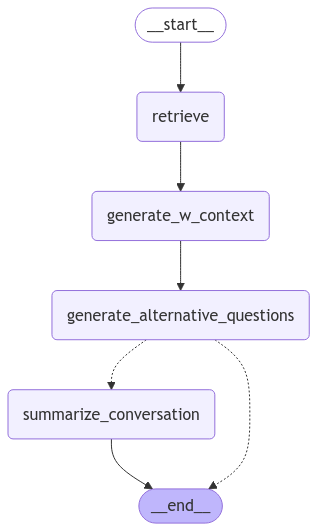

In [7]:
qa_model.workflow

In [8]:
prompt = 'My name is Dan. Please tell me about some interesting mecanism designs.'
# result = qa_model.workflow.invoke({"messages": [("human", prompt)]}, config)
qa_model.query(prompt)
for message in qa_model.result['messages']:
    message.pretty_print()

INFO:aerospace_chatbot.processing.queries:Running query through workflow: My name is Dan. Please tell me about some interesting mecanism designs.
INFO:aerospace_chatbot.processing.queries:Node: retrieve
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/Users/danmueller/Documents/GitHub/aerospace_chatbot/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
INFO:aerospace_chatbot.processing.queries:Retrieved docs
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:aerospace_chatbot.processing.queries:Reranked docs
INFO:aerospace_chatbot.processing.queries:Node: generate_w_conte

================================ Human Message =================================

My name is Dan. Please tell me about some interesting mecanism designs.
================================== Ai Message ==================================

One interesting mechanism design is the Starsys Research Qwknut 2000, which aims to maintain the ease of use of a separation nut while addressing several issues associated with traditional separation nuts. It features pyro-pulse compatibility, allowing for electrical initiation signals <source id="1">. Another notable design is the Multipurpose Holddown and Release Mechanism (MHRM) developed by Fokker Space. This mechanism uses an electrically heated Thermal Knife to cut an aramid (Kevlar) holddown cable, facilitating the release of solar arrays <source id="2">. Additionally, the MHRM design includes a Reel cable element clamped by a pretensioned Dyneema wire bundle, providing a robust holddown load <source id="5">.


In [9]:
qa_model.result['context']

[(Document(metadata={'data_source.url': 'gs://processing-pdfs/1999_christiansen_reocr.pdf', 'data_source.record_locator.protocol': 'gs', 'data_source.record_locator.remote_file_path': 'gs://processing-pdfs', 'file_directory': './document_processing', 'filename': '1999_christiansen_reocr.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-01-25T20:18:38', 'page_number': 1, 'orig_elements': 'eJztVttu3DYQ/RVCTw7g1ZK6kvsRRVq7T4YhUORoRUQSBZJaZxv03zvkrpvUsAP0wQ9pA+xC4uGc4XB4RpyHLxlMMMMSOqOzA8l6XrVlVbaSVwIG3je0HPq6UbRgemCtyG5JNkOQWgaJ9l8yZa3TZpEBfBpP8my30I1gjmNApCgoRc4VfjI6jIiyNqGrNUuIvIcHwUTe3hJOWc4fb8nzWPA2r+OY1VWbl68AFwYimT/7AHPcxUfzGaa7VSrI/sSJGGzn7eZwHGN0oDDobrJKBusStDobrLJTZB993KWD2QboBjNBt8oUNc4c9ns0VeC9WY67VQ8+rbC56a35PRNCdGp0xgcjFw9L58Aql+PkJToIoIKxS6cm6X2H/B6d0VyUtcAUZCkEbTBqjPYc18n32qotHdvX1bKr6SLnuM3se+teTcN5TaZyXSeDycAg9tfpSS7HTR7TqT5kgO4fE+pDN1ttBgNJLwUt6h1lu6K+L+iB8UPJI3tFZrdscw8xvSwh7qvKBllUTdv2gy4rqfu+ZozxQfG+lFLULU15CfA5Cii7H4FoOBkVH14504MmZiFhN